## v1.

- lag와 rolling 변수 생성
- 소비지역과 거주지역이 같은 지를 판단하는 변수 생성(CCG_IN) / 거주 시민의 구매 비율을 구함
- 업종별로 생애주기에 따라 소비 비율이 다른지 판단 -> 편차가 상대적으로 큰 생애가구(1,5)의 업종에 대한 구매비율을 계산함.


## Submission

- v1 : skfold + 3월 데이터 학습 제외
- v2 : skfold + 4월 데이터까지 학습

In [1]:
sub_ver = 1

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import gc

import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.metrics import mean_squared_error

import os
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

## Load data

In [3]:
df = pd.read_csv('../input/dacon-jeju/201901-202003.csv')
df4 = pd.read_csv('../input/dacon-jeju/202004.csv')
df = pd.concat([df, df4], axis=0)

sub = pd.read_csv('../input/dacon-jeju/submission.csv')

In [4]:
df.tail()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
1350317,202004,충북,충주시,휴양콘도 운영업,충북,충주시,20s,1,1,5,77000,5
1350318,202004,충북,충주시,휴양콘도 운영업,충북,충주시,30s,1,2,6,92000,6
1350319,202004,충북,충주시,휴양콘도 운영업,충북,충주시,40s,2,3,5,193000,5
1350320,202004,충북,충주시,휴양콘도 운영업,충북,충주시,50s,1,4,5,86000,7
1350321,202004,충북,충주시,휴양콘도 운영업,충북,충주시,60s,2,5,3,227000,4


In [5]:
def preprocess_df(df):
    # Mapping
    df['CARD_SIDO_NM'] = df['CARD_SIDO_NM'].map(sido_dict).astype('int16')
    df['CARD_CCG_NM'] = df['CARD_CCG_NM'].map(ccg_dict).astype('int16')
    df['HOM_SIDO_NM'] = df['HOM_SIDO_NM'].map(sido_dict).astype('int16')
    df['HOM_CCG_NM'] = df['HOM_CCG_NM'].map(ccg_dict).astype('int16')
    df['STD_CLSS_NM'] = df['STD_CLSS_NM'].map(clss_dict).astype('int16')
    df['AGE'] = df['AGE'].map(age_dict).astype('int16')

    # True or False
    df['SEX_CTGO_CD'] = df['SEX_CTGO_CD'] == 1

    # Float to int
    df['CSTMR_CNT'] = df['CSTMR_CNT'].astype(int)
    df['AMT'] = df['AMT'].astype(int)
    df['FLC'] = df['FLC'].astype('int16')
    df['CNT'] = df['CNT'].astype('int16')

    # 날짜 변경
    df['REG_YYMM'] = pd.to_datetime(df['REG_YYMM'], format='%Y%m')
    return df

In [6]:
# str -> int categorical features
sido_dict = {sido: num for num, sido in enumerate(df['CARD_SIDO_NM'].unique())}
ccg_dict = {ccg: num for num, ccg in enumerate(df['CARD_CCG_NM'].unique())}
clss_dict = {clss: num for num, clss in enumerate(df['STD_CLSS_NM'].unique())}
age_dict = {age: num for num, age in enumerate(df['AGE'].unique())}

r_age = dict(map(reversed, age_dict.items()))
r_sido = dict(map(reversed, sido_dict.items()))
r_ccg = dict(map(reversed, ccg_dict.items()))
r_clss = dict(map(reversed, clss_dict.items()))

df = preprocess_df(df)

In [7]:
df.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,2019-01-01,0,0,0,0,0,0,True,1,4,311200,4
1,2019-01-01,0,0,0,0,0,1,True,2,7,1374500,8
2,2019-01-01,0,0,0,0,0,1,False,2,6,818700,6
3,2019-01-01,0,0,0,0,0,2,True,3,4,1717000,5
4,2019-01-01,0,0,0,0,0,2,True,4,3,1047300,3


In [8]:
group = ['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']

## 소비 지역과 거주 지역이 같은지 판단하는 변수 `CCG_IN`

In [9]:
df['CCG_IN'] = df['CARD_CCG_NM'] == df['HOM_CCG_NM']

In [10]:
ccg_sum = df.groupby(group + ['CCG_IN'])['AMT'].sum().reset_index()
ccg_sum['CCG_IN_RATE'] = pd.Series(ccg_sum['AMT'] / ccg_sum.groupby(group)['AMT'].transform('sum') * 100).round(2)

def reduce_ccg(df):
    if len(df) == 1:
        if df.iloc[0]['CCG_IN'] == False:
            return 0
        return 100
    
    if df['CCG_IN'].iloc[0] == True:
        return df['CCG_IN_RATE'].iloc[0]
    return df['CCG_IN_RATE'].iloc[1]

ccg_sum = ccg_sum.groupby(group)[['CCG_IN', 'CCG_IN_RATE']].apply(reduce_ccg).reset_index()

In [11]:
ccg_sum.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,0
0,2019-01-01,0,0,98.50
1,2019-01-01,0,1,13.20
2,2019-01-01,0,2,58.50
3,2019-01-01,0,3,41.73
4,2019-01-01,0,4,99.89


각 월별로 시 안에서 구매비율이 나타난다.

In [12]:
sido, clss = 14, 21
print(r_sido[sido], r_clss[clss])
ccg_sum.loc[(ccg_sum['CARD_SIDO_NM'] == sido)&(ccg_sum['STD_CLSS_NM'] == clss)][10:]

#sido, clss = 16, 36
#print(r_sido[sido], r_clss[clss])
#ccg_sum.loc[(ccg_sum['CARD_SIDO_NM'] == sido)&(ccg_sum['STD_CLSS_NM'] == clss)]

제주 일식 음식점업


,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,0
6852,2019-11-01,14,21,76.54
7483,2019-12-01,14,21,78.82
8112,2020-01-01,14,21,78.77
8737,2020-02-01,14,21,85.35
9348,2020-03-01,14,21,85.62
9957,2020-04-01,14,21,86.99


In [13]:
# df를 받아서 `ccg_in_rate`값을 반환하는 함수
def make_ccg_in_rate(df):
    ccg_sum = df.groupby(group + ['CCG_IN'])['AMT'].sum().reset_index()
    ccg_sum['CCG_IN_RATE'] = pd.Series(ccg_sum['AMT'] / ccg_sum.groupby(group)['AMT'].transform('sum') * 100).round(2)
    
    def reduce_ccg(df):
        if len(df) == 1:
            if df.iloc[0]['CCG_IN'] == False:
                return 0
            return 100
        if df['CCG_IN'].iloc[0] == True:
            return df['CCG_IN_RATE'].iloc[0]
        return df['CCG_IN_RATE'].iloc[1]

    ccg_sum = ccg_sum.groupby(group)[['CCG_IN', 'CCG_IN_RATE']].apply(reduce_ccg).reset_index().rename(columns = {0 : 'CCG_IN_RATE'})
    #ccg_sum.rename(columns = {0 : 'CCG_IN_RATE'} ,inplace= True)
    return ccg_sum[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'CCG_IN_RATE']]

In [14]:
f = make_ccg_in_rate(df)

업종별로 생애주기에 따른 구매 비율에 차이가 있을까?

In [15]:
flc_sum = df.groupby(['STD_CLSS_NM', 'FLC'])['AMT'].sum().reset_index()
flc_sum['AMT_rate'] = flc_sum['AMT'] / flc_sum.groupby(['STD_CLSS_NM'])['AMT'].transform('sum') * 100

In [16]:
flc_sum.loc[flc_sum['STD_CLSS_NM'] == 0]

,STD_CLSS_NM,FLC,AMT,AMT_rate
0,0,1,1519900931,1.369768
1,0,2,14070314419,12.680477
2,0,3,14131397683,12.735526
3,0,4,37541132416,33.832894
4,0,5,43697707722,39.381335


업종 별 생애 주기에 따른 이용률을 나타낸 그래프다.

In [17]:
# 1인 가구의 이용률이 적은 업종
for i,j in flc_sum.loc[flc_sum['FLC'] == 1].iterrows():
    if j['AMT_rate'] < 5:
        print(r_clss[j['STD_CLSS_NM']])

건강보조식품 소매업
골프장 운영업
과실 및 채소 소매업
수산물 소매업
육류 소매업
차량용 가스 충전업
차량용 주유소 운영업
휴양콘도 운영업
여행사업


In [18]:
# 노년 가구의 이용률이 적은 업종
for i,j in flc_sum.loc[flc_sum['FLC'] == 5].iterrows():
    if j['AMT_rate'] < 5:
        print(r_clss[j['STD_CLSS_NM']])

그외 기타 스포츠시설 운영업
자동차 임대업
기타 수상오락 서비스업


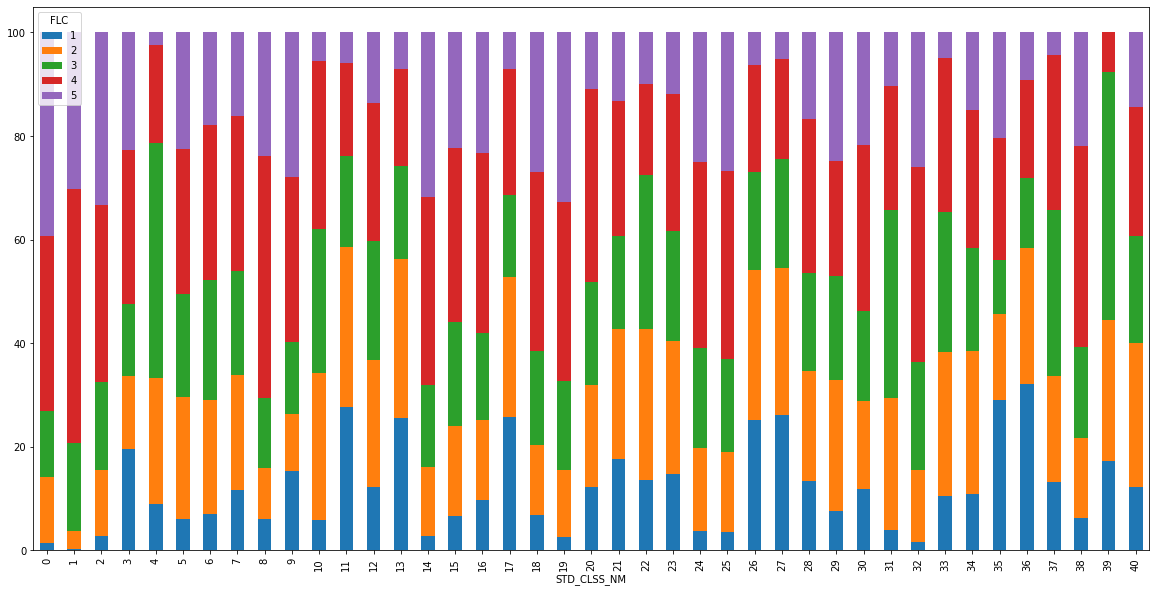

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
flc_sum.pivot(index='STD_CLSS_NM', columns='FLC', values='AMT_rate').plot.bar(stacked=True, ax=ax)

변동이 큰 두개의 집단인 1과 5의 점유율을 clss에 연결시킨다.

In [20]:
flc_sum.groupby('FLC').std()

,STD_CLSS_NM,AMT,AMT_rate
FLC,,,
1,11.979149,3.793830e+11,8.526871
2,11.979149,6.169084e+11,6.909654
3,11.979149,5.731075e+11,7.797428
4,11.979149,9.083890e+11,8.168428
5,11.734209,5.702810e+11,9.628321


In [21]:
clss_flc = flc_sum.loc[flc_sum['FLC'].isin([1,5])].pivot(index='STD_CLSS_NM', columns='FLC', values='AMT_rate').reset_index()
clss_flc.rename(columns={1:'FLC_1_rate', 5:'FLC_5_rate'}, inplace=True)
clss_flc.fillna(0, inplace=True)

추후에 STD_CLSS_NM 와 merge해서 사용한다.

In [22]:
clss_flc.head()

FLC,STD_CLSS_NM,FLC_1_rate,FLC_5_rate
0,0,1.369768,39.381335
1,1,0.206986,30.188918
2,2,2.819783,33.350679
3,3,19.515508,22.700873
4,4,8.977274,2.491737


In [23]:
def make_FLC_rate(df):
    flc_sum = df.groupby(['STD_CLSS_NM', 'FLC'])['AMT'].sum().reset_index()
    flc_sum['AMT_rate'] = pd.Series(flc_sum['AMT'] / flc_sum.groupby(['STD_CLSS_NM'])['AMT'].transform('sum') * 100).round(2)
    clss_flc = flc_sum.loc[flc_sum['FLC'].isin([1,5])].pivot(index='STD_CLSS_NM', columns='FLC', values='AMT_rate').reset_index()
    clss_flc.rename(columns={1:'FLC_1_rate', 5:'FLC_5_rate'}, inplace=True)
    clss_flc.fillna(0, inplace=True)
    return clss_flc

## 방문한 고객수(CNT)와 AMT의 상관관계

In [24]:
cnt_sum = df.groupby(group)[['CNT', 'AMT']].sum().reset_index()
cnt_sum.set_index(['CARD_SIDO_NM', 'STD_CLSS_NM'], inplace=True)

In [25]:
cnt_ex = cnt_sum.groupby(['CARD_SIDO_NM', 'STD_CLSS_NM'])['AMT'].count()
cnt_sum.drop(index = cnt_ex.loc[cnt_ex < 8].index).reset_index(inplace=True)
cnt_sum.reset_index(inplace=True)

In [26]:
cnt_corr = cnt_sum.groupby(['CARD_SIDO_NM', 'STD_CLSS_NM']).corr().reset_index()

In [27]:
cnt_corr.drop(cnt_corr.loc[cnt_corr['level_2'] == 'AMT'].index, inplace=True)

In [28]:
#cnt_corr.loc[cnt_corr['AMT'] < 0.5, 'STD_CLSS_NM'].apply(lambda x: print(r_clss[x]))

## 전체 기간의 모든 데이터가 존재하지 않는 지역 / 업종를 찾아보자.

In [29]:
count_df = df.groupby(group)['AMT'].sum().reset_index().groupby(group[1:])['AMT'].count().reset_index()

In [30]:
count_df.loc[count_df['AMT'] < 15]

,CARD_SIDO_NM,STD_CLSS_NM,AMT
34,0,34,5
35,0,35,13
36,0,36,14
39,0,39,1
77,1,38,11
78,1,39,4
150,3,32,12
152,3,35,13
155,3,38,13
156,3,39,5


## 지역 / 업종별 AMT 합계

## lag and rolling

In [31]:
def make_lag(df_sum, column, lag):
    col_name = f"{column}_lag_{lag}"
    df_sum[col_name] = df_sum.groupby(['CARD_SIDO_NM', 'STD_CLSS_NM'])[column].transform(lambda x: x.shift(lag))
    return df_sum

def make_lag_roll(df_sum, column, lag, is_std=False):
    shift = lag[0]
    roll = lag[1]
    
    mean_name = f"{column}_rolling_mean_{shift}_{roll}"
    df_sum[mean_name] = df_sum.groupby(['CARD_SIDO_NM', 'STD_CLSS_NM'])[column].transform(lambda x: x.shift(shift).rolling(roll).mean()).round()
    
    if is_std:
        std_name = f"{column}_rolling_std_{shift}_{roll}"
        df_sum[std_name] = df_sum.groupby(['CARD_SIDO_NM', 'STD_CLSS_NM'])[column].transform(lambda x: x.apply(np.log1p).shift(shift).rolling(roll).std()).round(2)
    return df_sum

In [32]:
def delete_by_count(df_sum):
    count_del = df_sum.groupby(['CARD_SIDO_NM', 'STD_CLSS_NM'])['AMT'].count()
    del_idx = count_del.loc[count_del <  10].index
    print(f"{len(del_idx)} find / df_sum : {len(df_sum)}")
    
    df_sum = df_sum.set_index(['CARD_SIDO_NM', 'STD_CLSS_NM'])
    df_sum.drop(del_idx, inplace=True)
    print(f"After df_sum : {len(df_sum)}")
    df_sum = df_sum.reset_index()
    return df_sum, del_idx

## Dataset

In [33]:
df_sum = df.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'])[['AMT', 'CNT']].sum().reset_index()

In [34]:
df_sum, del_idx = delete_by_count(df_sum)

23 find / df_sum : 10048
After df_sum : 9943


In [35]:
# 테스트할 월별 데이터를 추가한다.
for day in ['2020-05-01', '2020-06-01', '2020-07-01']:
    add_df =  df_sum.groupby(['CARD_SIDO_NM', 'STD_CLSS_NM']).first().reset_index().copy()
    add_df['REG_YYMM'] = pd.to_datetime(day)
    add_df['AMT'] = 0
    df_sum = pd.concat([df_sum, add_df], axis=0).reset_index(drop=True)
    del add_df
df_sum = df_sum.sort_values(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'])

In [36]:
# lag and rolling features
for lag in [3, 6]:
    df_sum = make_lag(df_sum, 'AMT', lag)

for lag in [[3,3]]:
    df_sum = make_lag_roll(df_sum, 'AMT', lag, is_std=True)

# CNT lag
df_sum = make_lag(df_sum, 'CNT', 3)

In [37]:
# CCG_IN_rate
df_sum = df_sum.merge(make_ccg_in_rate(df), on=group, how='left')

# CNT lag
df_sum = make_lag_roll(df_sum, 'CCG_IN_RATE', [3, 3])

# 빈 업계 데이터 수정
for idx, i in df_sum.groupby(group[1:])['CCG_IN_RATE']:
    if i.sum() == 0:
        df_sum.loc[i.index, 'CCG_IN_RATE'] = 0
        df_sum.loc[i.index, 'CCG_IN_RATE_rolling_mean_3_3'] = 0

In [38]:
# FLC 1 & 5
df_sum = df_sum.merge(make_FLC_rate(df), on='STD_CLSS_NM', how='left')

In [39]:
df_sum.loc[(df_sum['CARD_SIDO_NM'] == 16)& (df_sum['STD_CLSS_NM'] == 38)]

,CARD_SIDO_NM,STD_CLSS_NM,REG_YYMM,AMT,CNT,AMT_lag_3,AMT_lag_6,AMT_rolling_mean_3_3,AMT_rolling_std_3_3,CNT_lag_3,CCG_IN_RATE,CCG_IN_RATE_rolling_mean_3_3,FLC_1_rate,FLC_5_rate
1868,16,38,2019-03-01,1089000,62.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,6.18,21.86
2492,16,38,2019-04-01,6770500,148.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,6.18,21.86
3117,16,38,2019-05-01,11282500,302.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,6.18,21.86
3742,16,38,2019-06-01,3219500,110.0,1089000.0,NaN,NaN,NaN,62.0,0.0,0.0,6.18,21.86
4369,16,38,2019-07-01,2092000,67.0,6770500.0,NaN,NaN,NaN,148.0,0.0,0.0,6.18,21.86
4995,16,38,2019-08-01,14829000,373.0,11282500.0,NaN,6380667.0,1.23,302.0,0.0,0.0,6.18,21.86
5618,16,38,2019-09-01,3151000,107.0,3219500.0,1089000.0,7090833.0,0.63,110.0,0.0,0.0,6.18,21.86
6244,16,38,2019-10-01,12018500,325.0,2092000.0,6770500.0,5531333.0,0.88,67.0,0.0,0.0,6.18,21.86
6866,16,38,2019-11-01,7056000,215.0,14829000.0,11282500.0,6713500.0,1.03,373.0,0.0,0.0,6.18,21.86
7492,16,38,2019-12-01,262000,9.0,3151000.0,3219500.0,6690667.0,1.03,107.0,0.0,0.0,6.18,21.86


In [40]:
df_sum.loc[(df_sum['CARD_SIDO_NM'] == 0)& (df_sum['STD_CLSS_NM'] == 38)]

,CARD_SIDO_NM,STD_CLSS_NM,REG_YYMM,AMT,CNT,AMT_lag_3,AMT_lag_6,AMT_rolling_mean_3_3,AMT_rolling_std_3_3,CNT_lag_3,CCG_IN_RATE,CCG_IN_RATE_rolling_mean_3_3,FLC_1_rate,FLC_5_rate
37,0,38,2019-01-01,434000,19.0,NaN,NaN,NaN,NaN,NaN,34.10,NaN,6.18,21.86
658,0,38,2019-02-01,213000,13.0,NaN,NaN,NaN,NaN,NaN,54.93,NaN,6.18,21.86
1280,0,38,2019-03-01,1627000,81.0,NaN,NaN,NaN,NaN,NaN,18.32,NaN,6.18,21.86
1906,0,38,2019-04-01,2530000,124.0,434000.0,NaN,NaN,NaN,19.0,29.64,NaN,6.18,21.86
2530,0,38,2019-05-01,4988000,217.0,213000.0,NaN,NaN,NaN,13.0,24.02,NaN,6.18,21.86
3155,0,38,2019-06-01,4687358,140.0,1627000.0,NaN,758000.0,1.03,81.0,15.49,36.0,6.18,21.86
3780,0,38,2019-07-01,1939000,96.0,2530000.0,434000.0,1456667.0,1.32,124.0,7.74,34.0,6.18,21.86
4407,0,38,2019-08-01,6012000,280.0,4988000.0,213000.0,3048333.0,0.56,217.0,11.61,24.0,6.18,21.86
5033,0,38,2019-09-01,2447000,118.0,4687358.0,1627000.0,4068453.0,0.38,140.0,23.17,23.0,6.18,21.86
5656,0,38,2019-10-01,6640000,273.0,1939000.0,2530000.0,3871453.0,0.53,96.0,13.15,16.0,6.18,21.86


In [41]:
df_sum.loc[df_sum['REG_YYMM'] == '2020-02-01'].tail()

,CARD_SIDO_NM,STD_CLSS_NM,REG_YYMM,AMT,CNT,AMT_lag_3,AMT_lag_6,AMT_rolling_mean_3_3,AMT_rolling_std_3_3,CNT_lag_3,CCG_IN_RATE,CCG_IN_RATE_rolling_mean_3_3,FLC_1_rate,FLC_5_rate
8725,16,29,2020-02-01,11516930,448.0,53897740.0,29575440.0,40611633.0,0.27,958.0,62.00,64.0,7.56,24.85
8726,16,30,2020-02-01,495012925,10773.0,580160733.0,573856229.0,585919049.0,0.03,13857.0,77.16,74.0,11.90,21.69
8727,16,31,2020-02-01,47085830,913.0,124117555.0,476196855.0,138501997.0,0.29,2204.0,19.65,10.0,3.82,10.43
8728,16,36,2020-02-01,1541270,231.0,423120.0,83420.0,288892.0,0.84,64.0,37.17,55.0,32.07,9.12
8729,16,37,2020-02-01,628400,32.0,1082700.0,3600900.0,2166200.0,0.61,57.0,79.31,65.0,13.14,4.45


In [42]:
# 년/월 추가
df_sum['month'] = df_sum['REG_YYMM'].dt.month
df_sum['year'] = df_sum['REG_YYMM'].dt.year

# 날짜도 변경
#df_sum['REG_YYMM'] = df_sum.groupby(['CARD_SIDO_NM', 'STD_CLSS_NM'])['REG_YYMM'].shift(3)

In [43]:
# 훈련할 수 없는 null이 포함된 데이터 삭제
df_sum.drop(columns=['CNT', 'CCG_IN_RATE'], inplace=True)

df_sum = df_sum.dropna(subset=['AMT_lag_6']).reset_index(drop=True)

In [44]:
df_sum.loc[(df_sum['CARD_SIDO_NM'] == 16)& (df_sum['STD_CLSS_NM'] == 38)]

,CARD_SIDO_NM,STD_CLSS_NM,REG_YYMM,AMT,AMT_lag_3,AMT_lag_6,AMT_rolling_mean_3_3,AMT_rolling_std_3_3,CNT_lag_3,CCG_IN_RATE_rolling_mean_3_3,FLC_1_rate,FLC_5_rate,month,year
1859,16,38,2019-09-01,3151000,3219500.0,1089000.0,7090833.0,0.63,110.0,0.0,6.18,21.86,9,2019
2484,16,38,2019-10-01,12018500,2092000.0,6770500.0,5531333.0,0.88,67.0,0.0,6.18,21.86,10,2019
3105,16,38,2019-11-01,7056000,14829000.0,11282500.0,6713500.0,1.03,373.0,0.0,6.18,21.86,11,2019
3730,16,38,2019-12-01,262000,3151000.0,3219500.0,6690667.0,1.03,107.0,0.0,6.18,21.86,12,2019
4351,16,38,2020-01-01,84000,12018500.0,2092000.0,9999500.0,0.84,325.0,0.0,6.18,21.86,1,2020
6180,16,38,2020-04-01,45000,7056000.0,14829000.0,7408500.0,0.67,215.0,0.0,6.18,21.86,4,2020
6807,16,38,2020-05-01,0,262000.0,3151000.0,6445500.0,2.07,9.0,0.0,6.18,21.86,5,2020
7434,16,38,2020-06-01,0,84000.0,12018500.0,2467333.0,2.30,3.0,0.0,6.18,21.86,6,2020
8061,16,38,2020-07-01,0,45000.0,7056000.0,130333.0,0.89,3.0,0.0,6.18,21.86,7,2020


In [45]:
df_sum.loc[(df_sum['CARD_SIDO_NM'] == 0)& (df_sum['STD_CLSS_NM'] == 38)]

,CARD_SIDO_NM,STD_CLSS_NM,REG_YYMM,AMT,AMT_lag_3,AMT_lag_6,AMT_rolling_mean_3_3,AMT_rolling_std_3_3,CNT_lag_3,CCG_IN_RATE_rolling_mean_3_3,FLC_1_rate,FLC_5_rate,month,year
36,0,38,2019-07-01,1939000,2530000.0,434000.0,1456667.0,1.32,124.0,34.0,6.18,21.86,7,2019
654,0,38,2019-08-01,6012000,4988000.0,213000.0,3048333.0,0.56,217.0,24.0,6.18,21.86,8,2019
1275,0,38,2019-09-01,2447000,4687358.0,1627000.0,4068453.0,0.38,140.0,23.0,6.18,21.86,9,2019
1897,0,38,2019-10-01,6640000,1939000.0,2530000.0,3871453.0,0.53,96.0,16.0,6.18,21.86,10,2019
2521,0,38,2019-11-01,2842000,6012000.0,4988000.0,4212786.0,0.59,280.0,12.0,6.18,21.86,11,2019
3143,0,38,2019-12-01,148000,2447000.0,4687358.0,3466000.0,0.60,118.0,14.0,6.18,21.86,12,2019
3768,0,38,2020-01-01,260000,6640000.0,1939000.0,5033000.0,0.55,273.0,16.0,6.18,21.86,1,2020
4389,0,38,2020-02-01,363000,2842000.0,6012000.0,3976333.0,0.54,131.0,21.0,6.18,21.86,2,2020
5003,0,38,2020-03-01,458000,148000.0,2447000.0,3210000.0,2.00,9.0,24.0,6.18,21.86,3,2020
5610,0,38,2020-04-01,912000,260000.0,6640000.0,1083333.0,1.57,15.0,19.0,6.18,21.86,4,2020


In [46]:
df_sum.tail()

,CARD_SIDO_NM,STD_CLSS_NM,REG_YYMM,AMT,AMT_lag_3,AMT_lag_6,AMT_rolling_mean_3_3,AMT_rolling_std_3_3,CNT_lag_3,CCG_IN_RATE_rolling_mean_3_3,FLC_1_rate,FLC_5_rate,month,year
8057,16,31,2020-07-01,0,9328420.0,222073112.0,23049247.0,0.86,180.0,21.0,3.82,10.43,7,2020
8058,16,33,2020-07-01,0,305050.0,1036000.0,715617.0,0.65,3.0,57.0,10.49,4.99,7,2020
8059,16,36,2020-07-01,0,1379350.0,1796540.0,1304660.0,0.23,217.0,34.0,32.07,9.12,7,2020
8060,16,37,2020-07-01,0,961000.0,1409900.0,843800.0,0.24,59.0,72.0,13.14,4.45,7,2020
8061,16,38,2020-07-01,0,45000.0,7056000.0,130333.0,0.89,3.0,0.0,6.18,21.86,7,2020


## Model training

In [47]:
def model_dataset(df_sum):
    # Define columns
    categorical_features = ['month', 'year', 'CARD_SIDO_NM', 'STD_CLSS_NM']
    train_columns = df_sum.columns[:][~df_sum.columns[:].isin(['AMT', 'REG_YYMM'])]

    train_data = df_sum.loc[df_sum['REG_YYMM'] <= '2020-04-01'].reset_index(drop=True)
    test_data = df_sum.loc[df_sum['REG_YYMM'] > '2020-04-01'].reset_index(drop=True)

    #train_data.drop(train_data.loc[train_data['lag_3'] == -99].index, inplace=True)
    #train_data.loc[train_data['AMT'] == -99, 'AMT'] = 0
    #train_data.drop(train_data.loc[train_data['AMT'] == -99, 'AMT'].index, inplace=True)

    # AMT를 로그 변환 & lag_3도 변환
    #train_data['lag_3'] = np.log1p(train_data['lag_3'])
    
    print(f"Total columns : {len(train_columns)} / ({list(train_columns[:10])})")
    print(f"Train data : {len(train_data)} / Test data : {len(test_data)}")
    return categorical_features, train_columns, train_data, test_data

In [48]:
categorical_features, train_columns, train_data, test_data = model_dataset(df_sum)

Total columns : 12 / (['CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT_lag_3', 'AMT_lag_6', 'AMT_rolling_mean_3_3', 'AMT_rolling_std_3_3', 'CNT_lag_3', 'CCG_IN_RATE_rolling_mean_3_3', 'FLC_1_rate', 'FLC_5_rate'])
Train data : 6181 / Test data : 1881


In [49]:
def run_lgb():
    params = {'verbose': 100,
              'learning_rate': 0.015,
              'metric': 'rmse',
              #'bagging_freq': 3
              'boosting_type': 'gbdt',
              'eval_metric': 'rmse',
              'objective': 'tweedie',
              'tweedie_variance_power': 1.1,
              'n_jobs': -1,
             #'objective': 'regression',
              'seed': 42}
    oof_pred = np.zeros(shape=(len(train_data)))
    y_pred = np.zeros(shape=(len(test_data)))

    features = pd.DataFrame()

    #kf = KFold(n_splits=6, shuffle=True, random_state=220)
    skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=200)

    #for num, (tr_idx, val_idx) in enumerate(kf.split(train_data)):
    for num, (tr_idx, val_idx) in enumerate(skf.split(train_data[train_columns], train_data['STD_CLSS_NM'])):
        print('=' * 50)
        print(f'{num+1} fold Train')
        lgb_train = lgb.Dataset(train_data[train_columns].iloc[tr_idx], np.log1p(train_data['AMT'].iloc[tr_idx]), 
                                categorical_feature=categorical_features)
        lgb_valid = lgb.Dataset(train_data[train_columns].iloc[val_idx], np.log1p(train_data['AMT'].iloc[val_idx]), 
                              categorical_feature=categorical_features)

        model = lgb.train(params, lgb_train, num_boost_round = 100000, early_stopping_rounds = 200, 
                                 valid_sets = [lgb_train, lgb_valid], verbose_eval = 500)

        oof_pred[val_idx] = model.predict(train_data[train_columns].iloc[val_idx])
        y_pred += model.predict(test_data[train_columns]) / 6 
        features[f'importance_{num}'] = model.feature_importance()

    print('=' * 50)
    print(f"model oof_pred rmse error :{mean_squared_error(np.log1p(train_data['AMT']), oof_pred)**1/2}")
    print('=' * 50)

    features['importance'] = features[[col for col in features.columns if col.startswith('importance')]].mean(axis=1)
    features['columns'] = model.feature_name()
    return model, features, oof_pred, y_pred

In [50]:
model, features, oof_pred, y_pred = run_lgb()

1 fold Train
Training until validation scores don't improve for 200 rounds


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[500]	training's rmse: 0.275158	valid_1's rmse: 0.408966
[1000]	training's rmse: 0.204879	valid_1's rmse: 0.394076
[1500]	training's rmse: 0.162785	valid_1's rmse: 0.389471
Early stopping, best iteration is:
[1610]	training's rmse: 0.157265	valid_1's rmse: 0.388942
2 fold Train
Training until validation scores don't improve for 200 rounds
[500]	training's rmse: 0.272172	valid_1's rmse: 0.449733
[1000]	training's rmse: 0.202689	valid_1's rmse: 0.441722
[1500]	training's rmse: 0.15918	valid_1's rmse: 0.436451
[2000]	training's rmse: 0.125695	valid_1's rmse: 0.432433
[2500]	training's rmse: 0.105824	valid_1's rmse: 0.430244
[3000]	training's rmse: 0.0890598	valid_1's rmse: 0.428425
[3500]	training's rmse: 0.0766575	valid_1's rmse: 0.427633
[4000]	training's rmse: 0.0661568	valid_1's rmse: 0.426396
[4500]	training's rmse: 0.0571631	valid_1's rmse: 0.425425
[5000]	training's rmse: 0.0504681	valid_1's rmse: 0.424859
[5500]	training's rmse: 0.0446785	valid_1's rmse: 0.424244
Early stopping, b

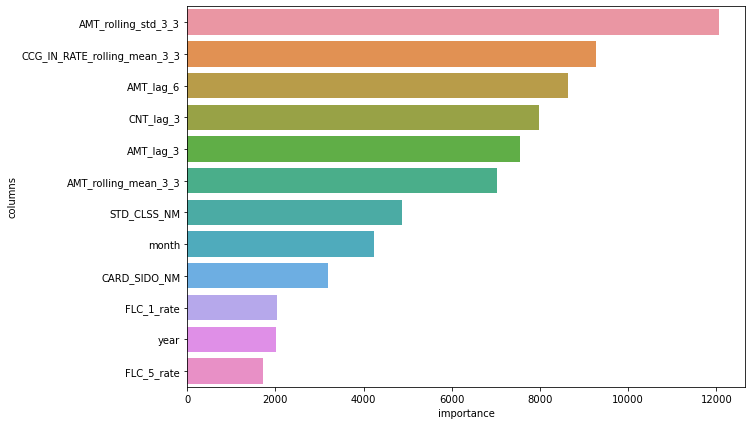

In [51]:
fig, ax= plt.subplots(1,1, figsize=(10, 7))
sns.barplot(x='importance', y='columns', data=features.sort_values('importance', ascending=False)[:20])
plt.show()

In [52]:
#model2, features, oof_pred, y_pred2 = run_lgb()

## 4월달 비교

In [53]:
assert len(test_data) == len(y_pred)
test_data['AMT'] = np.exp(y_pred)

In [54]:
mean_squared_error(np.log1p(test_data.loc[test_data['REG_YYMM'] == '2020-04-01', 'AMT']), np.log1p(test_data.loc[test_data['REG_YYMM'] == '2020-04-01', 'pred']))

KeyError: 'pred'

In [55]:
test_data.head()

,CARD_SIDO_NM,STD_CLSS_NM,REG_YYMM,AMT,AMT_lag_3,AMT_lag_6,AMT_rolling_mean_3_3,AMT_rolling_std_3_3,CNT_lag_3,CCG_IN_RATE_rolling_mean_3_3,FLC_1_rate,FLC_5_rate,month,year
0,0,0,2020-05-01,1.038875e+08,76505561.0,9.808464e+07,1.189155e+08,0.46,726.0,97.0,1.37,39.38,5,2020
1,0,1,2020-05-01,1.830533e+09,968456455.0,4.017470e+09,1.149849e+09,0.14,12451.0,15.0,0.21,30.19,5,2020
2,0,2,2020-05-01,1.195650e+09,867214360.0,1.052642e+09,1.155059e+09,0.31,23616.0,66.0,2.82,33.35,5,2020
3,0,3,2020-05-01,1.810019e+07,16375500.0,3.094007e+07,2.548175e+07,0.35,745.0,42.0,19.52,22.70,5,2020
4,0,4,2020-05-01,3.069707e+06,5065100.0,6.808100e+06,5.418900e+06,0.18,76.0,100.0,8.98,2.49,5,2020


In [56]:
test_data['REG_YYMM'] = test_data['REG_YYMM'].dt.to_period('M').astype(str).str.replace('-', '')
test_data['REG_YYMM'] = test_data['REG_YYMM'].astype(int)

test_data['CARD_SIDO_NM'] = test_data['CARD_SIDO_NM'].map(dict(map(reversed, sido_dict.items())))
test_data['STD_CLSS_NM'] = test_data['STD_CLSS_NM'].map(dict(map(reversed, clss_dict.items())))

In [57]:
test_data.loc[(test_data['CARD_SIDO_NM'] == '강원')&(test_data['STD_CLSS_NM'] == '건강보조식품 소매업')]

,CARD_SIDO_NM,STD_CLSS_NM,REG_YYMM,AMT,AMT_lag_3,AMT_lag_6,AMT_rolling_mean_3_3,AMT_rolling_std_3_3,CNT_lag_3,CCG_IN_RATE_rolling_mean_3_3,FLC_1_rate,FLC_5_rate,month,year
0,강원,건강보조식품 소매업,202005,1.038875e+08,76505561.0,98084641.0,118915547.0,0.46,726.0,97.0,1.37,39.38,5,2020
627,강원,건강보조식품 소매업,202006,1.022392e+08,96059012.0,95232313.0,119191114.0,0.46,833.0,98.0,1.37,39.38,6,2020
1254,강원,건강보조식품 소매업,202007,7.807694e+07,88823988.0,185008768.0,87129520.0,0.12,862.0,99.0,1.37,39.38,7,2020


In [58]:
'''# 제주도에 사는 사람이 제주도에서 소비한 금액과 다른 시도에서 소비한 AMT 비교
temp = df.groupby(['REG_YYMM', 'HOM_SIDO_NM', 'STD_CLSS_NM', 'CCG_IN'])['AMT'].sum().reset_index()
plt.figure(figsize=(16, 10))
sns.lineplot(x = 'REG_YYMM', y = 'AMT', hue= 'CCG_IN', data = temp.loc[temp['HOM_SIDO_NM'] == 16].groupby(['REG_YYMM', 'CCG_IN'])['AMT'].sum().reset_index())
plt.show()'''

"# 제주도에 사는 사람이 제주도에서 소비한 금액과 다른 시도에서 소비한 AMT 비교\ntemp = df.groupby(['REG_YYMM', 'HOM_SIDO_NM', 'STD_CLSS_NM', 'CCG_IN'])['AMT'].sum().reset_index()\nplt.figure(figsize=(16, 10))\nsns.lineplot(x = 'REG_YYMM', y = 'AMT', hue= 'CCG_IN', data = temp.loc[temp['HOM_SIDO_NM'] == 16].groupby(['REG_YYMM', 'CCG_IN'])['AMT'].sum().reset_index())\nplt.show()"

In [59]:
sub2 = sub.copy()
sub2.drop(columns='AMT', inplace=True)

sub2 = sub2.merge(test_data[test_data.columns[:4]], on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
sub2.fillna(0, inplace=True)

In [60]:
sub2

,id,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,0,202004,강원,건강보조식품 소매업,0.000000e+00
1,1,202004,강원,골프장 운영업,0.000000e+00
2,2,202004,강원,과실 및 채소 소매업,0.000000e+00
3,3,202004,강원,관광 민예품 및 선물용품 소매업,0.000000e+00
4,4,202004,강원,그외 기타 분류안된 오락관련 서비스업,0.000000e+00
...,...,...,...,...,...
1389,1389,202007,충북,피자 햄버거 샌드위치 및 유사 음식점업,1.407402e+09
1390,1390,202007,충북,한식 음식점업,1.905381e+10
1391,1391,202007,충북,호텔업,1.054606e+07
1392,1392,202007,충북,화장품 및 방향제 소매업,4.342333e+08


In [61]:
sub2.to_csv(f'submission_org_v{sub_ver}.csv', index=False)